<a href="https://colab.research.google.com/github/muajnstu/Bank-Marketing-using-rough-set-approach/blob/main/Explainability_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import textwrap

import shap

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
)



In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/muajnstu/Bank-Marketing-using-rough-set-approach/refs/heads/main/df_rus%20(1).csv")

In [3]:

X = df.drop(['DBSCAN_Cluster','Personal Loan'], axis=1)
y = df['DBSCAN_Cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


In [15]:
model = ExtraTreesClassifier(random_state=42)
model.fit(X_train, y_train)


X_train = X_train.drop(['DBSCAN_Cluster', 'Personal Loan'], axis=1, errors='ignore')

explainer = shap.TreeExplainer(model)

X_test_shap = X_test.drop(['DBSCAN_Cluster', 'Personal Loan'], axis=1, errors='ignore')
shap_values = explainer.shap_values(X_test_shap)

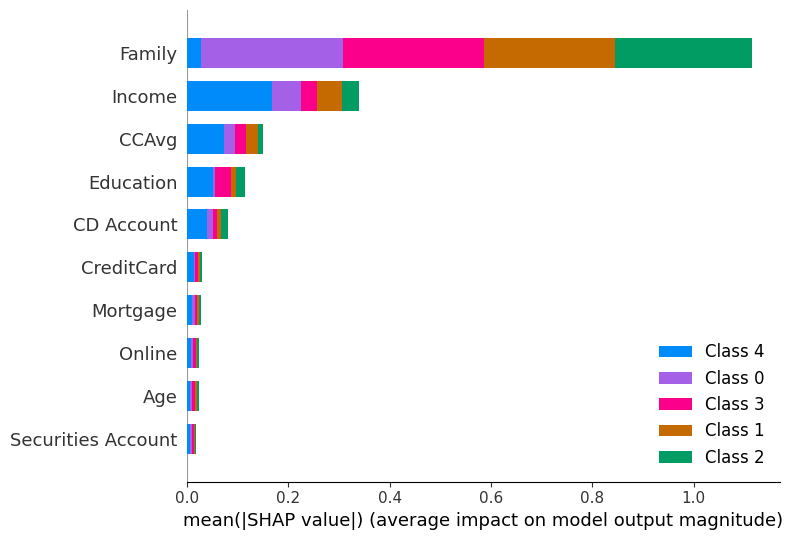

In [16]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

<Figure size 300x800 with 0 Axes>

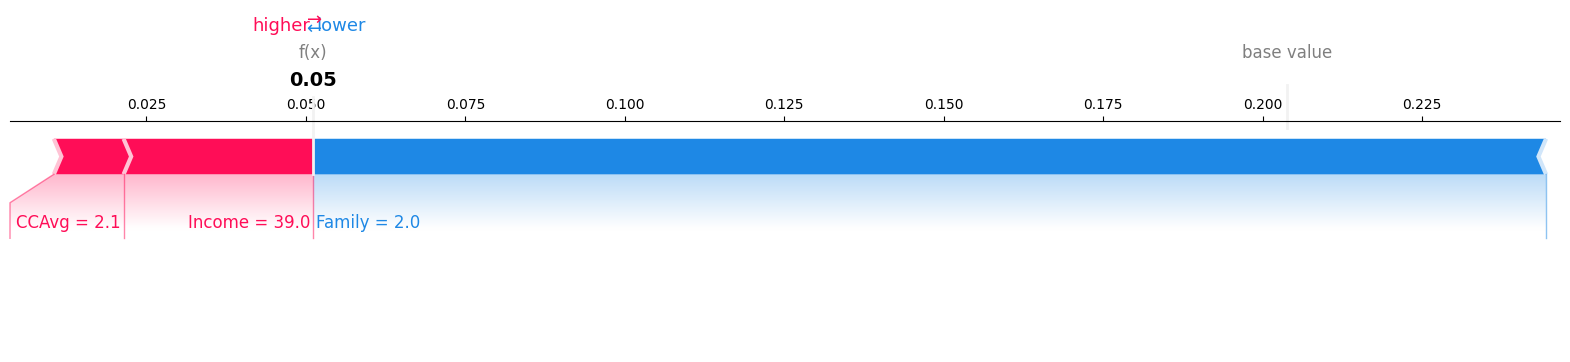

In [24]:
sample_index = 0
class_idx = 1
top_k = 3

if isinstance(shap_values, list):
    vals = shap_values[class_idx][sample_index, :]
else:

    if shap_values.ndim == 3:
        if shap_values.shape[-1] == len(explainer.expected_value): # Check if last dim matches number of classes
             vals = shap_values[sample_index, :, class_idx]
        elif shap_values.shape[0] == len(explainer.expected_value):
             vals = shap_values[class_idx, sample_index, :]
        else:
             raise ValueError(f"Unexpected shap_values shape for numpy array: {shap_values.shape}")
    else:
         raise ValueError(f"Unexpected shap_values shape for numpy array: {shap_values.shape}")


if hasattr(explainer, 'expected_value') and isinstance(explainer.expected_value, (list, np.ndarray)):
    if isinstance(explainer.expected_value, list):
         base = explainer.expected_value[class_idx]
    else:
         base = explainer.expected_value[class_idx]
else:

    print("Warning: explainer.expected_value not found or in expected format.")

    raise AttributeError("Could not access expected_value from explainer.")



X_test_plot_data = X_test.drop(['DBSCAN_Cluster', 'Personal Loan'], axis=1, errors='ignore')
data = X_test_plot_data.iloc[sample_index, :].values

feature_names = X_test_plot_data.columns.tolist()

top_idx = np.argsort(np.abs(vals))[-top_k:]
top_idx_sorted = np.sort(top_idx)

vals_top = vals[top_idx_sorted]
feat_vals_top = data[top_idx_sorted]
feat_names_top = [feature_names[i] for i in top_idx_sorted]

feature_names_top_wrapped = [textwrap.fill(str(n).replace('_', ' '), width=18) for n in feat_names_top]

exp = shap.Explanation(
    values=vals_top[np.newaxis, :],
    base_values=np.array([base]), # Base value needs to be in an array
    data=feat_vals_top[np.newaxis, :],
    feature_names=list(feat_names_top)
)

plt.figure(figsize=(3, 8))
shap.plots.force(exp[0], matplotlib=True)
plt.show()

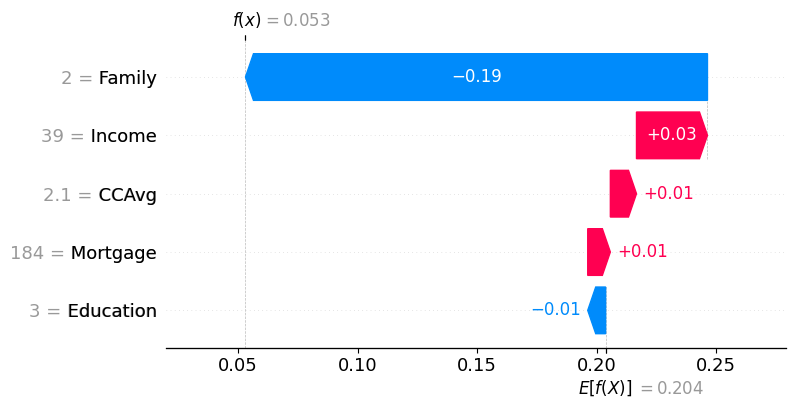

In [18]:
shap_vals_for_waterfall = vals_top
shap.plots.waterfall(shap.Explanation(values=shap_vals_for_waterfall,
                                      base_values=base,
                                      data=feat_vals_top,
                                      feature_names=list(feat_names_top)))

# LIME

In [ ]:
!pip install lime

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd

In [28]:

def predict_proba_func(x):

    if x.ndim == 1:
        x = x.reshape(1, -1)
    if x.shape[1] != X_train.shape[1]:
        print(f"Warning: Input shape mismatch. Expected {X_train.shape[1]} features, but got {x.shape[1]}.")
    x_df = pd.DataFrame(x, columns=X_train.columns)

    return model.predict_proba(x_df)

feature_names = X_train.columns.tolist()

class_names = [str(c) for c in np.unique(y_train)]

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

sample_to_explain_index = 0
sample_to_explain = X_test.iloc[sample_to_explain_index].values


explanation = explainer.explain_instance(
    data_row=sample_to_explain,
    predict_fn=predict_proba_func,
    num_features=10,
    num_samples=5000
)

In [27]:

explanation.show_in_notebook(show_table=True, show_all=False)

# Partial Dependence Plots (PDP) / Individual Conditional Expectation (ICE)

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay


In [36]:
pdp_importance = []

for i, feature in enumerate(X.columns):
    pdp_results = partial_dependence(model, X_train, [i], kind='average')

    feature_range = np.ptp(pdp_results.average[0], axis=0)  # ptp = max-min

    importance_score = np.mean(feature_range)

    pdp_importance.append((feature, importance_score))

# Convert to DataFrame and sort
pdp_importance_df = pd.DataFrame(pdp_importance, columns=['Feature', 'PDP_Importance'])
pdp_importance_df = pdp_importance_df.sort_values(by='PDP_Importance', ascending=True)


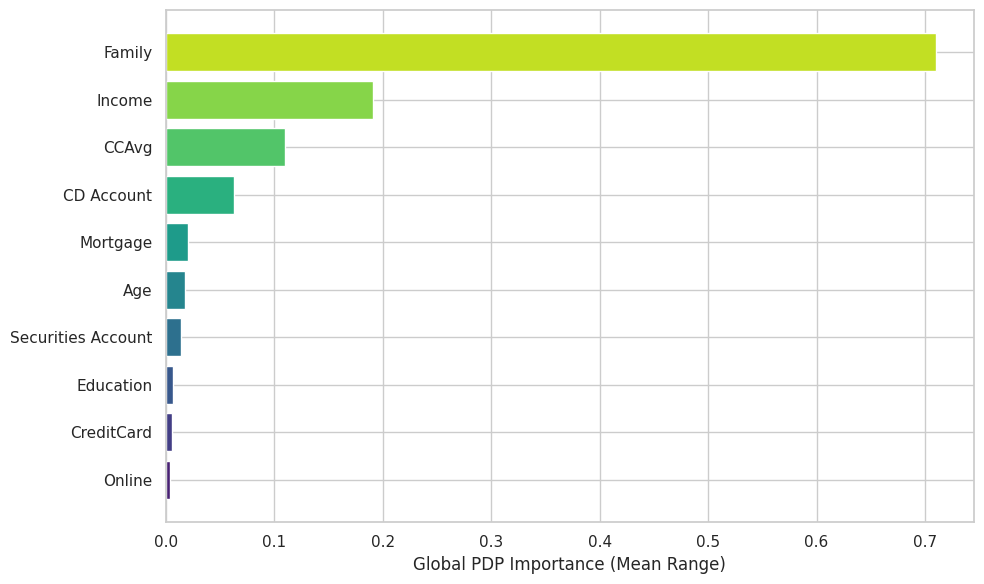

In [39]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
colors = sns.color_palette("viridis", len(pdp_importance_df))  # eye-catching gradient
plt.barh(pdp_importance_df['Feature'], pdp_importance_df['PDP_Importance'], color=colors)
plt.xlabel('Global PDP Importance (Mean Range)', fontsize=12)
plt.ylabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

plt.savefig("PDP_Global_Feature_Importance.png", dpi=300)
plt.show()


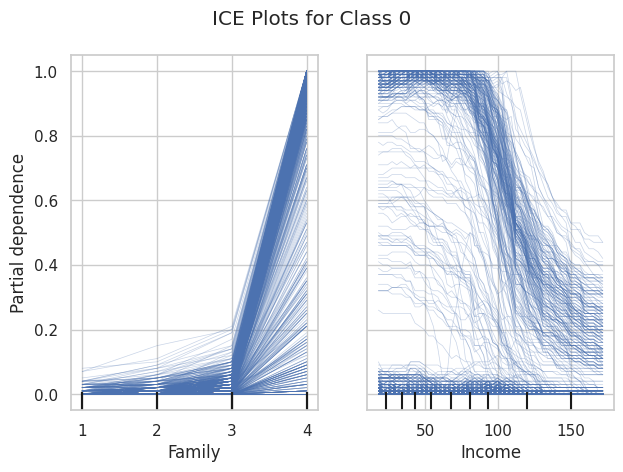

In [38]:
features_to_plot = ['Family', 'Income']  # column names or indices
target_class = 0

display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=features_to_plot,
    target=target_class,
    kind='individual',
    grid_resolution=50,
)

plt.suptitle(f'ICE Plots for Class {target_class}')
plt.tight_layout()
plt.show()